In [27]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import zscore

from matplotlib import pyplot as plt

from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [28]:
# Load datasets
sp500_train = pd.read_csv('Datasets/sp500_train.csv', index_col='Date', parse_dates=True)
sp500_test = pd.read_csv('Datasets/sp500_test.csv', index_col='Date', parse_dates=True)
tesla_train = pd.read_csv('Datasets/tesla_train.csv', index_col='Date', parse_dates=True)
tesla_test = pd.read_csv('Datasets/tesla_test.csv', index_col='Date', parse_dates=True)

print(sp500_train.head())


                  Close
Date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
2015-01-06  2002.609985
2015-01-07  2025.900024
2015-01-08  2062.139893


In [29]:
#LSTM model - SP500

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
sp500_train_scaled = scaler.fit_transform(sp500_train)
sp500_test_scaled = scaler.transform(sp500_test)

# Sequence
time_steps = 60  # Number of time steps to look back
train_generator_sp500 = TimeseriesGenerator(sp500_train_scaled, sp500_train_scaled, length=time_steps, batch_size=32)
test_generator_sp500 = TimeseriesGenerator(sp500_test_scaled, sp500_test_scaled, length=time_steps, batch_size=32)

#Building the LSTM model
model_sp500 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1),
    ])


Optimizer = Adam(learning_rate=0.00005)
model_sp500.compile(optimizer=Optimizer, loss='mean_squared_error')

model_sp500.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_sp500 = ModelCheckpoint('best_model_sp500.keras', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 2)

model_sp500_fit = model_sp500.fit(train_generator_sp500, epochs=40, validation_data=test_generator_sp500, callbacks=[early_stopping, checkpoint_sp500])

prediction_sp500 = model_sp500.predict(test_generator_sp500)



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2929
Epoch 1: val_loss improved from inf to 0.74507, saving model to best_model_sp500.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.2911 - val_loss: 0.7451
Epoch 2/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0582
Epoch 2: val_loss improved from 0.74507 to 0.03236, saving model to best_model_sp500.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0579 - val_loss: 0.0324
Epoch 3/40
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0098
Epoch 3: val_loss improved from 0.03236 to 0.03123, saving model to best_model_sp500.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0098 - val_loss: 0.0312
Epoch 4/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0071
Epoch 4: val_loss improved from 0.03123 to 0.00850, saving model to best_model_sp500.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 5/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0057
Epoch 5: val_l

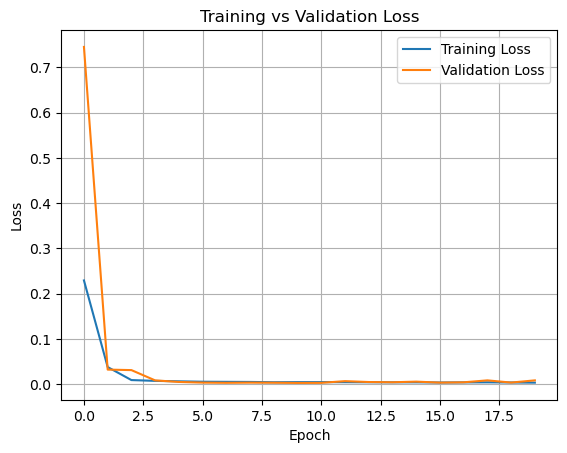

In [30]:
plt.plot(model_sp500_fit.history['loss'], label='Training Loss')
plt.plot(model_sp500_fit.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

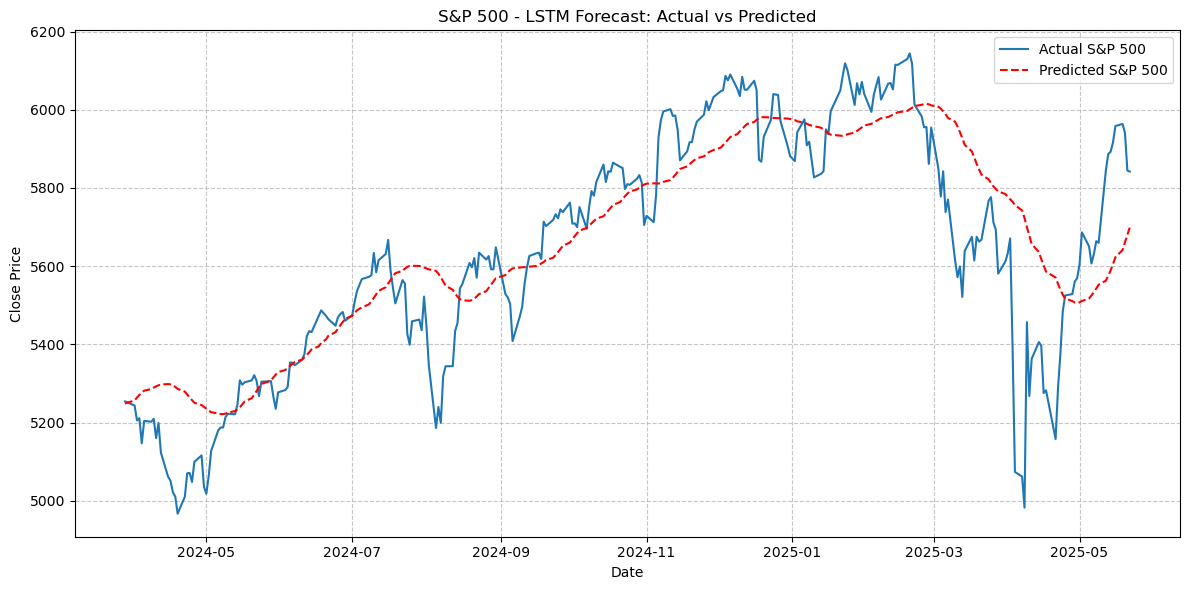

In [31]:
# Reconstruct the actual test values aligned with the predictions

# Inverse transform the predictions back to original scale
prediction_sp500_unscaled = scaler.inverse_transform(prediction_sp500)
actual_sp500_unscaled = scaler.inverse_transform(sp500_test_scaled[time_steps:])  # Original scaled test values

# Build a dataframe for comparison
results_sp500 = pd.DataFrame({
    'Date': sp500_test.iloc[time_steps:].index,
    'Actual': actual_sp500_unscaled.flatten(),
    'Predicted': prediction_sp500_unscaled.flatten()
})
results_sp500.set_index('Date', inplace=True)



# Plot the actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results_sp500['Actual'], label='Actual S&P 500')
plt.plot(results_sp500['Predicted'], label='Predicted S&P 500', linestyle='--', color = 'r')
plt.title('S&P 500 - LSTM Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.grid(which='major', axis='both', linestyle='--', alpha=0.7)

plt.show()

S&P 500 - RMSE: 160.55, MAE: 118.24, MAPE: 0.02
Z-Score for S&P 500 predictions:


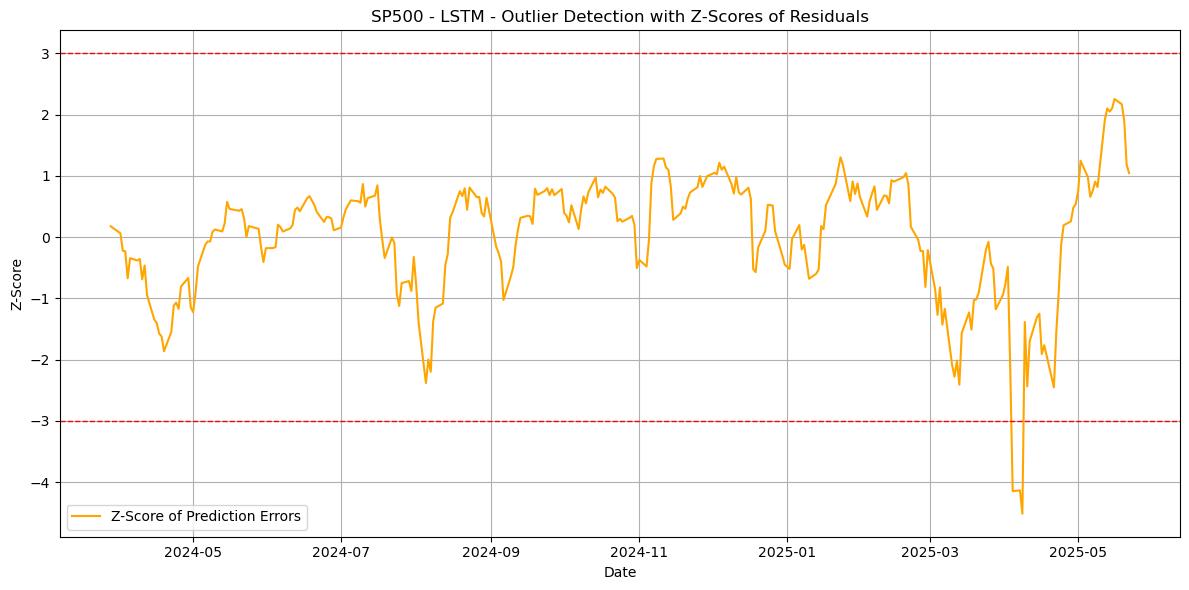

In [32]:
mse_sp500 = mean_squared_error(results_sp500['Actual'], results_sp500['Predicted'])
rmse_sp500 = np.sqrt(mse_sp500)
mae_sp500 = mean_absolute_error(results_sp500['Actual'], results_sp500['Predicted'])
mape_sp500 = mean_absolute_percentage_error(results_sp500['Actual'], results_sp500['Predicted'])
mape_sp500_percent = mape_sp500 * 100
print(f"S&P 500 - RMSE: {rmse_sp500:.2f}, MAE: {mae_sp500:.2f}, MAPE: {mape_sp500:.2f}")

#z-score calculation
zscore_sp500 = zscore(results_sp500['Actual'] - results_sp500['Predicted']) 
print("Z-Score for S&P 500 predictions:")

plt.figure(figsize=(12, 6))
plt.plot(results_sp500.index, zscore_sp500, label='Z-Score of Prediction Errors', color='orange')
plt.axhline(3, color='red', linestyle='--', linewidth=1)
plt.axhline(-3, color='red', linestyle='--', linewidth=1)
plt.title('SP500 - LSTM - Outlier Detection with Z-Scores of Residuals')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [33]:
#LSTM model - Tesla

# Normalize the data
tesla_test_scaled = scaler.fit_transform(tesla_test)
tesla_train_scaled = scaler.transform(tesla_train)

time_steps_tesla = 60  # Number of time steps to look back
train_generator_tesla = TimeseriesGenerator(tesla_train_scaled, tesla_train_scaled, length=time_steps_tesla, batch_size=32)
test_generator_tesla = TimeseriesGenerator(tesla_test_scaled, tesla_test_scaled, length=time_steps_tesla, batch_size=32)

# Building the LSTM model for Tesla
model_tesla = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps_tesla, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences = False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1),
])
Optimizer_tesla = Adam(learning_rate=0.00005)
model_tesla.compile(optimizer = Optimizer_tesla, loss='mean_squared_error')

model_tesla.summary()
checkpoint_tesla = ModelCheckpoint('best_model_tesla.keras', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 2)


# Fit the model
model_tesla_fit = model_tesla.fit(train_generator_tesla, epochs=20, validation_data=train_generator_tesla, callbacks=[early_stopping, checkpoint_tesla])

prediction_tesla = model_tesla.predict(test_generator_tesla)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1106
Epoch 1: val_loss improved from inf to 0.04647, saving model to best_model_tesla.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.1100 - val_loss: 0.0465
Epoch 2/20
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0309
Epoch 2: val_loss improved from 0.04647 to 0.00528, saving model to best_model_tesla.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0307 - val_loss: 0.0053
Epoch 3/20
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0064
Epoch 3: val_loss improved from 0.00528 to 0.00326, saving model to best_model_tesla.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0056
Epoch 4: val_loss improved from 0.00326 to 0.00311, saving model to best_model_tesla.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0041
Epoch 5: val_l

Text(0.5, 0, 'Date')

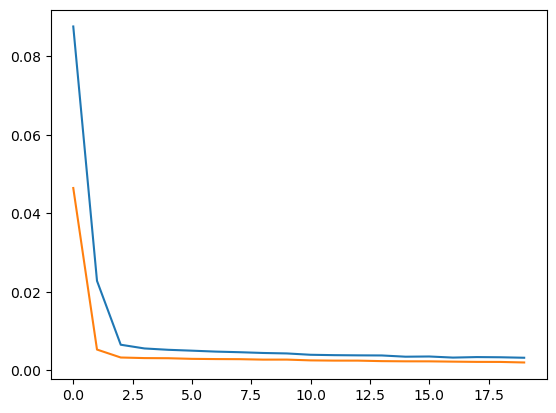

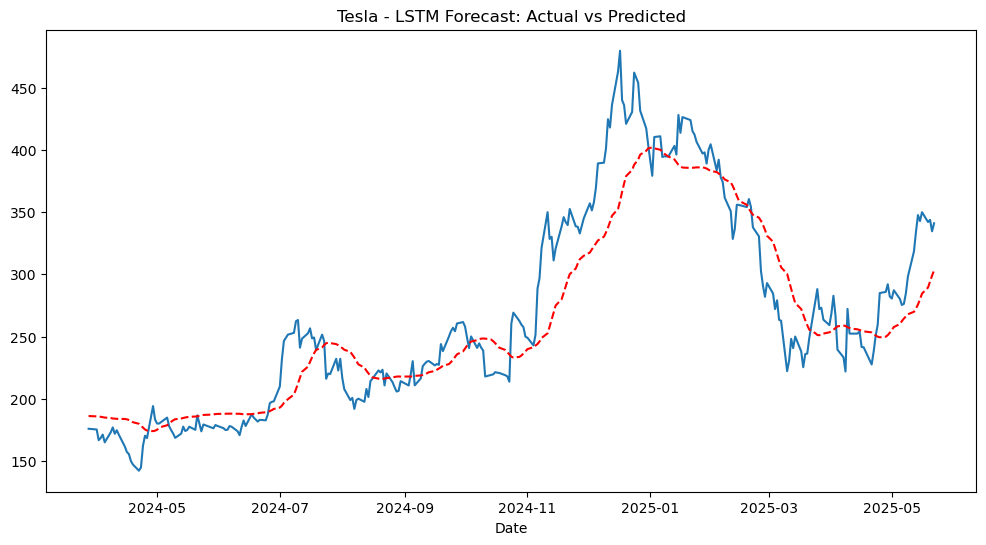

In [34]:
plt.plot(model_tesla_fit.history['loss'], label='Training Loss')
plt.plot(model_tesla_fit.history['val_loss'], label='Validation Loss')

prediction_tesla_unscaled = scaler.inverse_transform(prediction_tesla)
tesla_test_unscaled = scaler.inverse_transform(tesla_test_scaled[time_steps_tesla:])

result_tesla = pd.DataFrame({
    'Date': tesla_test.iloc[time_steps_tesla:].index,
    'Actual TSLA': tesla_test_unscaled.flatten(),
    'Predicted': prediction_tesla_unscaled.flatten()
})
result_tesla.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(result_tesla['Actual TSLA'], label='Actual TSLA')
plt.plot(result_tesla['Predicted'], label = 'Predicted TSLA', linestyle='--', color = 'r')
plt.title('Tesla - LSTM Forecast: Actual vs Predicted')
plt.xlabel('Date')


Tesla - Mean Absolute Error: 24.02925986319677
Tesla - Mean Absolute Percentage Error: 0.0878696464081911
Tesla - Root Mean Squared Error: 31.814388341051387


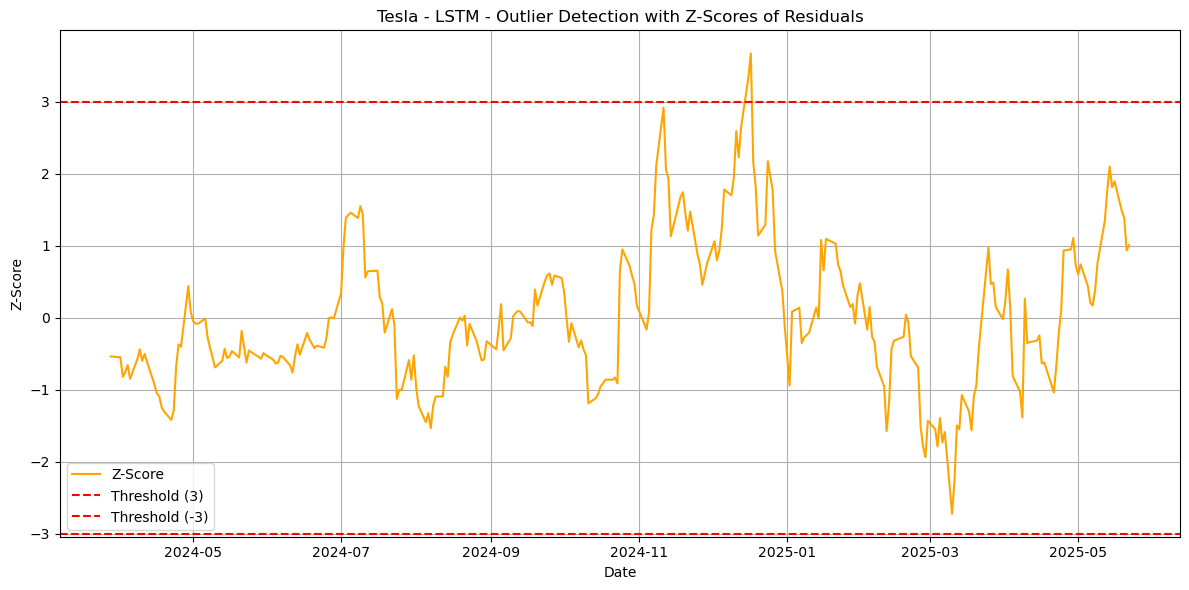

In [35]:
# Calculate and print evaluation metrics for S&P 500
mae_tesla = mean_absolute_error(result_tesla['Actual TSLA'], result_tesla['Predicted'])
mape_tesla = mean_absolute_percentage_error(result_tesla['Actual TSLA'], result_tesla['Predicted'])
mse_tesla = mean_squared_error(result_tesla['Actual TSLA'], result_tesla['Predicted'])
rmse_tesla = np.sqrt(mse_tesla)
mape_tesla_percent = mape_tesla * 100



print(f'Tesla - Mean Absolute Error: {mae_tesla}')
print(f'Tesla - Mean Absolute Percentage Error: {mape_tesla}')
print(f'Tesla - Root Mean Squared Error: {rmse_tesla}')

# Calulate the z-score
result_tesla['Z-Score'] = zscore(result_tesla['Actual TSLA'] - result_tesla['Predicted'])
plt.figure(figsize=(12,6)) 
plt.plot(result_tesla['Z-Score'], label='Z-Score', color='orange')
plt.title('Tesla - LSTM - Outlier Detection with Z-Scores of Residuals')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.axhline(y=3, color='r', linestyle='--', label='Threshold (3)')
plt.axhline(y=-3, color='r', linestyle='--', label='Threshold (-3)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



In [37]:
metrics_df = pd.read_csv('Metrics.csv')

arima_metrics = [
    {'Model':'LSTM', 'Stock':'S&P 500', 'RMSE':rmse_sp500, 'MAE': mae_sp500, 'MAPE': mape_sp500_percent},
    {'Model':'LSTM', 'Stock':'Tesla', 'RMSE':rmse_tesla, 'MAE': mae_tesla, 'MAPE': mape_tesla_percent}
]

metrics_df = pd.concat([metrics_df, pd.DataFrame(arima_metrics)])

metrics_df.to_csv('Metrics.csv', index=False)